<a href="https://colab.research.google.com/github/abakm/ADDM/blob/master/CaseStudy03ComputerVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the libraries

In [190]:
import os
import cv2
import kagglehub
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models

## Dowload dataset from kaggle

In [191]:

path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fruit-and-vegetable-image-recognition


# Set Target size for images and group items into categories

In [192]:
#categories
TARGET_SIZE = 64
fruits = ["banana", "apple", "pear", "grapes", "orange", "kiwi", "watermelon", "pomegranate", "pineapple", "mango"]
vegetables = ["cucumber", "carrot", "capsicum", "onion", "potato", "lemon", "tomato", "radish", "beetroot", "cabbage", "lettuce", "spinach", "soybean", "cauliflower", "bell pepper", "chilly", "pepper", "turnip", "corn", "sweetcorn", "sweet potato", "paprika", "jalapeño", "ginger", "garlic", "peas", "eggplant"]

## Group data into train and test dataset

In [193]:

train_images = list()
train_labels = list()

test_images = list()
test_labels = list()

for root, _, image_files in os.walk(path):
    for image_file in image_files:
      root_lower = root.lower()
      # Load only train and test samples
      if "train" in root_lower or "test" in root_lower:
        print("file:", os.path.join(root, image_file))

        img = cv2.imread(os.path.join(root, image_file))
        if img is not None:

          # resize the image
          img = cv2.resize(img, (TARGET_SIZE, TARGET_SIZE))

          # find whether its fruit or vegetable
          category = str(root.split("/")[-1]).lower()
          if category in fruits:
              label = 0
          elif category in vegetables:
              label = 1
          else:
              continue

          # Decide to whether the image needs to append(train/test)
          if "train" in root_lower:
              train_images.append(img)
              train_labels.append(label)
          else:
              test_images.append(img)
              test_labels.append(label)


file: /kaggle/input/fruit-and-vegetable-image-recognition/test/capsicum/Image_4.jpg
file: /kaggle/input/fruit-and-vegetable-image-recognition/test/capsicum/Image_2.jpg
file: /kaggle/input/fruit-and-vegetable-image-recognition/test/capsicum/Image_7.jpg
file: /kaggle/input/fruit-and-vegetable-image-recognition/test/capsicum/Image_5.jpg
file: /kaggle/input/fruit-and-vegetable-image-recognition/test/capsicum/Image_10.jpg
file: /kaggle/input/fruit-and-vegetable-image-recognition/test/capsicum/Image_1.jpg
file: /kaggle/input/fruit-and-vegetable-image-recognition/test/capsicum/Image_8.jpg
file: /kaggle/input/fruit-and-vegetable-image-recognition/test/capsicum/Image_3.JPG
file: /kaggle/input/fruit-and-vegetable-image-recognition/test/capsicum/Image_6.jpg
file: /kaggle/input/fruit-and-vegetable-image-recognition/test/capsicum/Image_9.jpg
file: /kaggle/input/fruit-and-vegetable-image-recognition/test/sweetcorn/Image_4.jpg
file: /kaggle/input/fruit-and-vegetable-image-recognition/test/sweetcorn/I

## Convert the train and test data into numpy array

In [194]:

train_images = np.array(train_images)
train_labels = np.array(train_labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

## Visualize Sample Images

Visualize 5 fruits and 5 vegetables

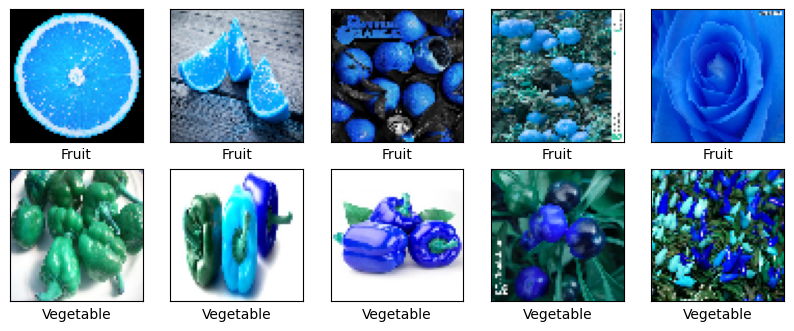

In [195]:
fruit_5_indexes = np.where(train_labels == 0)[0].tolist()
veg_5_indexes = np.where(train_labels == 1)[0].tolist()

indexes = fruit_5_indexes[:5] + veg_5_indexes[:5]
plt.figure(figsize=(10,10))
for index, i in enumerate(indexes):
    plt.subplot(5,5,index+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel("Vegetable" if train_labels[i] else "Fruit")
plt.show()


## Scale data with respect to 255

In [196]:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

## Analysis

In [197]:
print("Train data shape: ", train_images.shape)
print("Test data shape: ", test_images.shape)

Train data shape:  (2692, 64, 64, 3)
Test data shape:  (309, 64, 64, 3)


### Create Convolution Network

In [198]:
model = models.Sequential()
# First hidden layer
model.add(layers.Conv2D(TARGET_SIZE, (3, 3), activation='relu', input_shape=(TARGET_SIZE, TARGET_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Second hidden layer
model.add(layers.Conv2D(2*TARGET_SIZE, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Third hidden layer
model.add(layers.Conv2D(2*TARGET_SIZE, (3, 3), activation='relu'))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Create Fully Connected ANN

In [199]:
# Flatten and add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(2*TARGET_SIZE, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

# Compile the model

In [200]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

In [201]:
history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


85/85 ━━━━━━━━━━━━━━━━━━━━ 49s 551ms/step - accuracy: 0.6382 - loss: 0.6715 - val_accuracy: 0.7184 - val_loss: 0.6004
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 527ms/step - accuracy: 0.6948 - loss: 0.6010 - val_accuracy: 0.7023 - val_loss: 0.5817
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 83s 537ms/step - accuracy: 0.6993 - loss: 0.5815 - val_accuracy: 0.7508 - val_loss: 0.5160
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 45s 534ms/step - accuracy: 0.7139 - loss: 0.5385 - val_accuracy: 0.7573 - val_loss: 0.4959
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 86s 585ms/step - accuracy: 0.7171 - loss: 0.5268 - val_accuracy: 0.7896 - val_loss: 0.4556
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 46s 538ms/step - accuracy: 0.7312 - loss: 0.5041 - val_accuracy: 0.8155 - val_loss: 0.4146
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 81s 525ms/step - accuracy: 0.7669 - loss: 0.4741 - val_accuracy: 0.7767 - val_loss: 0.4785
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 45s 534ms/step - accuracy: 0.7483 - loss: 0.5010 - val_accuracy: 0.890

# Evaluate model

In [202]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Test accuracy: {test_acc}')

10/10 - 2s - 195ms/step - accuracy: 0.8835 - loss: 0.3284
Test accuracy: 0.8834951519966125


## Predict the model

In [204]:
print("test_label: ", test_labels[13])
prediction =model.predict(test_images[23].reshape(1, TARGET_SIZE, TARGET_SIZE, 3))
print("Prediction: ", prediction)
predicted_class = np.argmax(prediction)
print("Vegetable/fruit:", "Vegetable" if predicted_class else "Fruit")

test_label:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction:  [[0.3915051  0.60849494]]
Vegetable/fruit: Vegetable
